In [4]:
# Import required libraries
import os
import zipfile
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Function to parse tables
def parse_table_new(lines, header_format):
    table = []
    for line in lines:
        if line.startswith("#"):
            header = line[1:].split("\t")  # Remove "#" and split by tabs
            header = [h.split(" ")[0] for h in header]  # Keep only the first word of each header element
        else:
            values = line.split("\t")
            row = dict(zip(header, values))
            table.append(row)
    return table

In [23]:
# Specify the paths for the zip file and the extraction directory
zip_path = '/home1/mkato/hdd_data/data/0-0-raw_vcf/stats/stats.zip'
unzip_dir = '/home1/mkato/hdd_data/data/0-0-raw_vcf/stats/unzip'
os.makedirs(unzip_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

unzipped_files = os.listdir(unzip_dir)

# Extracting QUAL and DP tables from the stats files
dp_data = {}

for file_name in unzipped_files:
    individual = file_name.split('_')[0]
    stats_path = os.path.join(unzip_dir, file_name)

    dp_section = []
    in_dp = False
    
    with open(stats_path, 'r') as f:
        for line in f:
            cols = line.strip().split("\t")
            if cols[0].startswith("# DP"):
                in_dp = True
                dp_section.append(line.strip())
                continue
            if in_dp:
                dp_section.append(line.strip())

    dp_data[individual] = parse_table_new(dp_section, header_format="DP")

# Convert the extracted data to Pandas DataFrames
dp_dfs = {}

dp_columns = {
    '[2]id': 'id',
    '[3]bin': 'bin',
    '[4]number': 'number_of_genotypes',
    '[5]fraction': 'fraction_of_genotypes',
    '[6]number': 'number_of_sites',
    '[7]fraction': 'fraction_of_sites'
}


for individual, data in dp_data.items():
    dp_df = pd.DataFrame(data)
    dp_df.rename(columns=dp_columns, inplace=True)
    dp_df.drop(columns=[''], inplace=True)
    dp_df = dp_df.apply(pd.to_numeric, errors='ignore')
    # 列名を指定して最後の行を取得（'column_name'を実際の列名に置き換える）
    last_row = dp_df['bin'].iloc[-1]
    # 文字列を確認し、含まれている場合はその行を削除
    special_string = '>500'
    if special_string == last_row:
        dp_df = dp_df.iloc[:-1]  # 最後の行を削除
    dp_df['bin'] = dp_df['bin'].astype(int)
    dp_dfs[individual] = dp_df

print(dp_dfs['T5'].head())

   id  bin  number_of_genotypes  fraction_of_genotypes  number_of_sites  \
0   0    1                    0                    0.0           992824   
1   0    2                    0                    0.0          6545761   
2   0    3                    0                    0.0          3083251   
3   0    4                    0                    0.0          7744395   
4   0    5                    0                    0.0          4408505   

   fraction_of_sites  
0           0.048673  
1           0.320902  
2           0.151155  
3           0.379665  
4           0.216125  


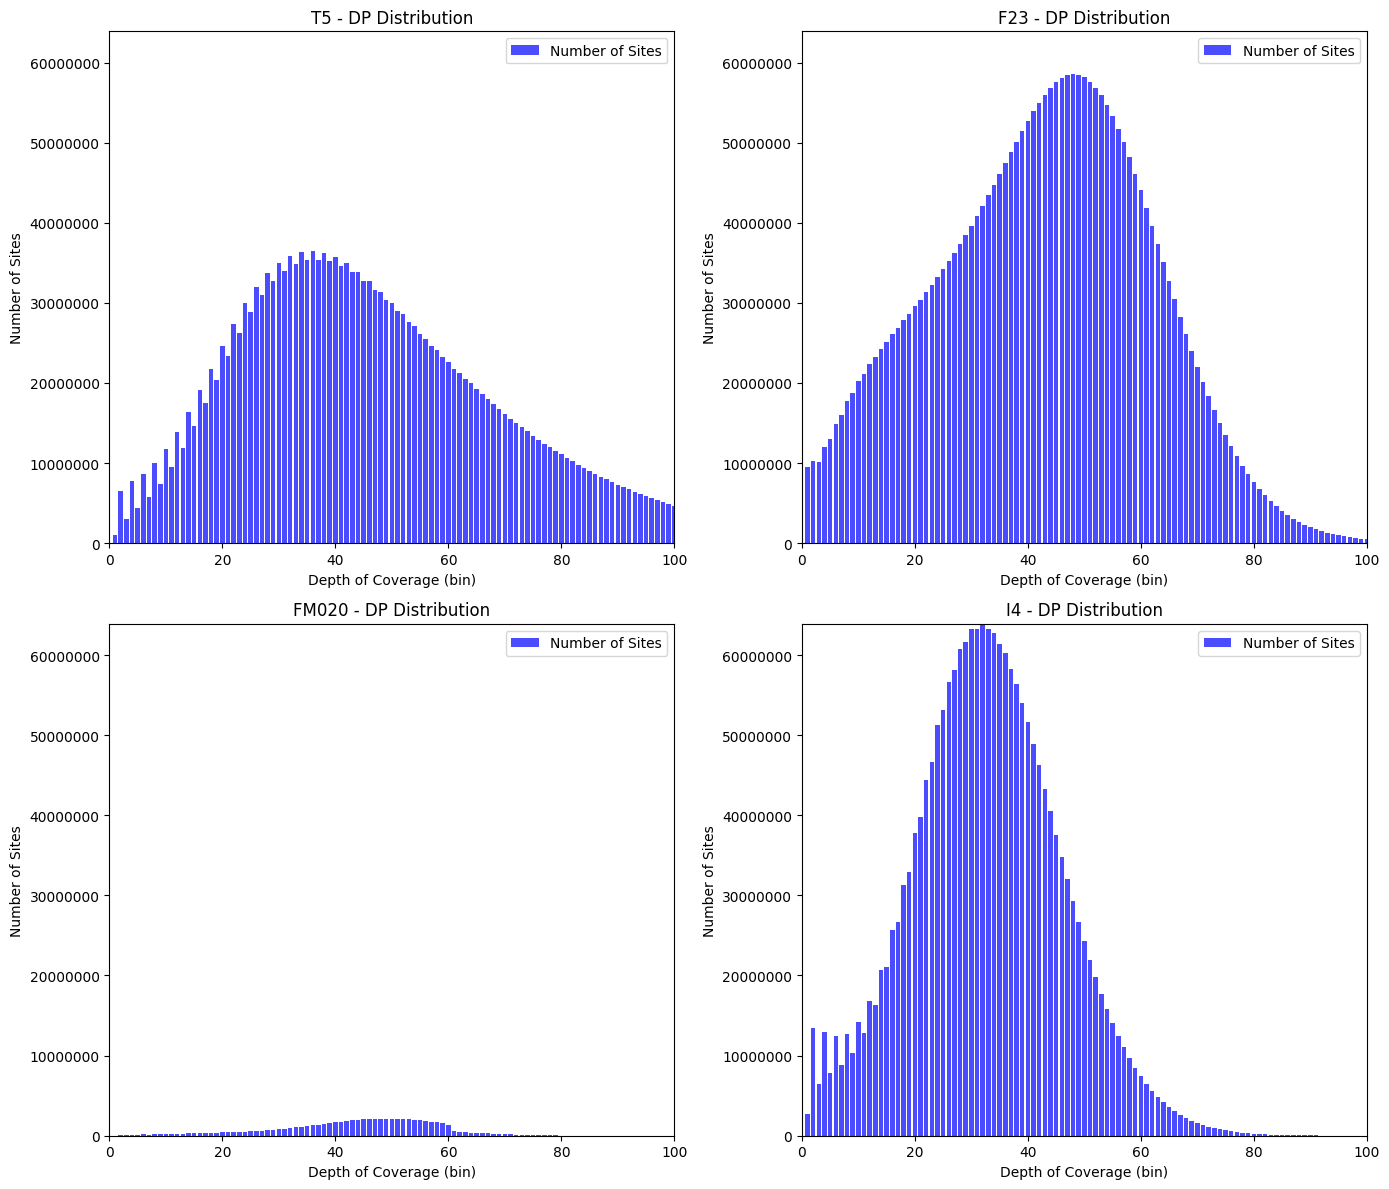

In [24]:
# Plotting the histograms for DP data
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()
max_y_value = max([df['number_of_sites'].max() for df in dp_dfs.values()])

for i, (individual, dp_df) in enumerate(dp_dfs.items()):
    ax = axes[i]
    filtered_df = dp_df[dp_df['bin'] <= 100]
    ax.bar(filtered_df['bin'], filtered_df['number_of_sites'], color='blue', alpha=0.7, label='Number of Sites')
    ax.set_title(f"{individual} - DP Distribution")
    ax.set_xlabel("Depth of Coverage (bin)")
    ax.set_ylabel("Number of Sites")
    ax.set_xlim(0, 100)
    ax.set_ylim(0, max_y_value)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.legend()

plt.tight_layout()
plt.show()

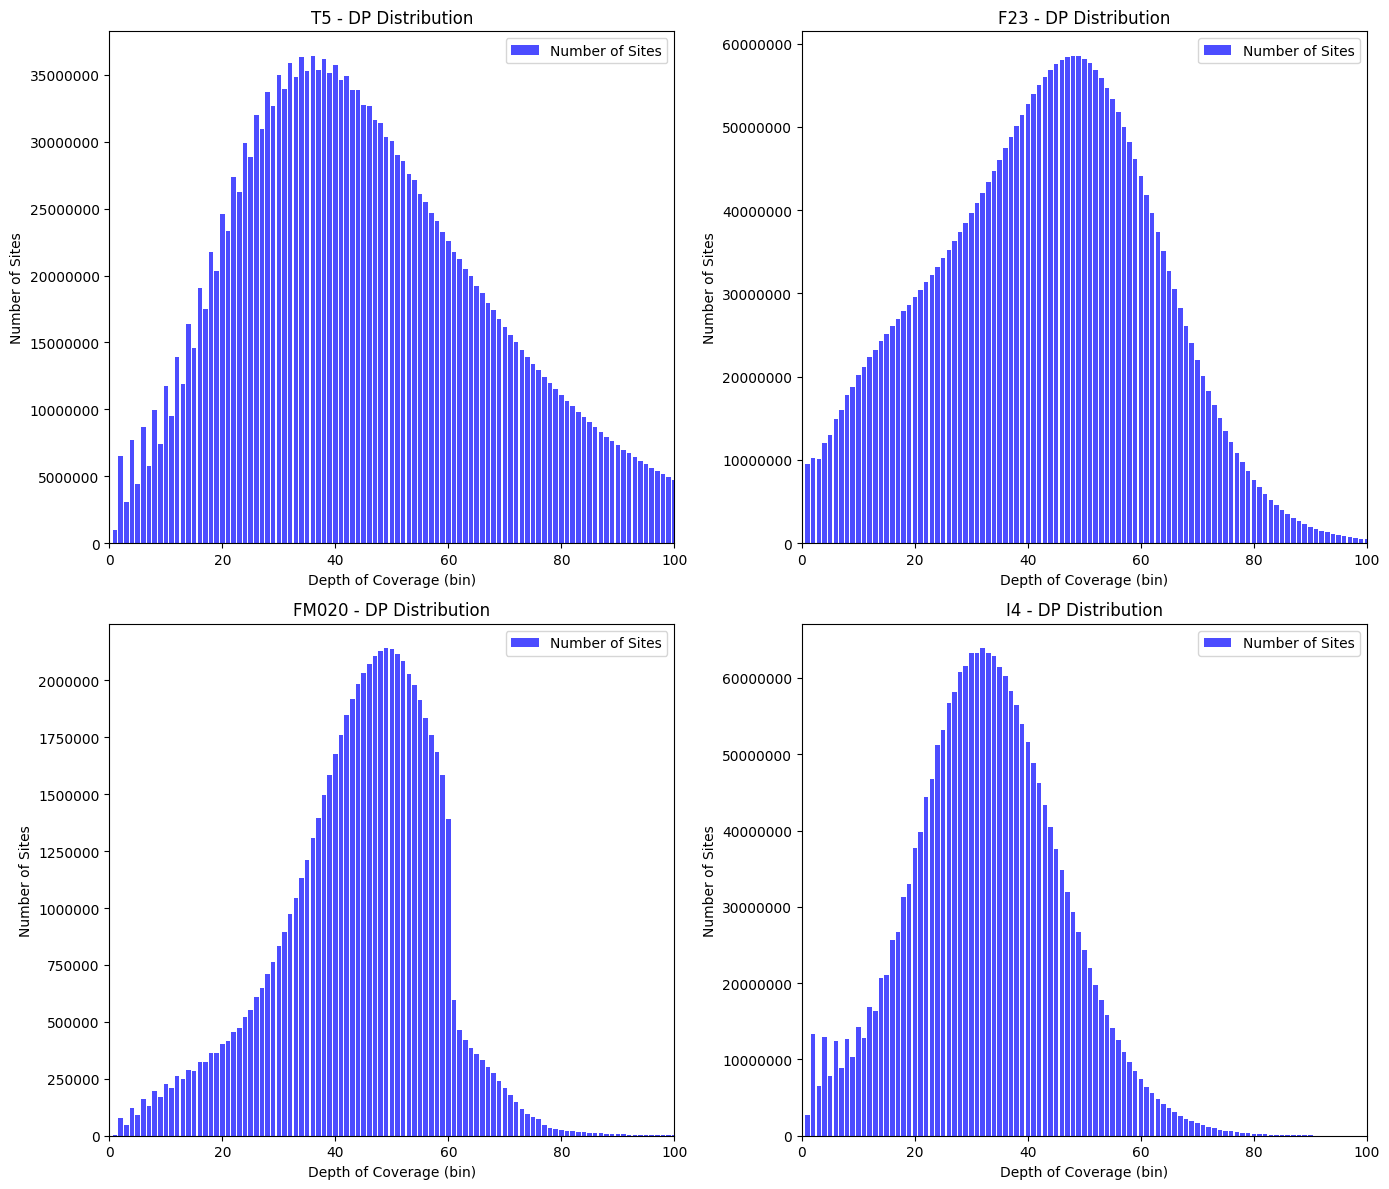

In [25]:
# Plotting the histograms for DP data
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()
max_y_value = max([df['number_of_sites'].max() for df in dp_dfs.values()])

for i, (individual, dp_df) in enumerate(dp_dfs.items()):
    ax = axes[i]
    filtered_df = dp_df[dp_df['bin'] <= 100]
    ax.bar(filtered_df['bin'], filtered_df['number_of_sites'], color='blue', alpha=0.7, label='Number of Sites')
    ax.set_title(f"{individual} - DP Distribution")
    ax.set_xlabel("Depth of Coverage (bin)")
    ax.set_ylabel("Number of Sites")
    ax.set_xlim(0, 100)
    #ax.set_ylim(0, max_y_value)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.legend()

plt.tight_layout()
plt.show()

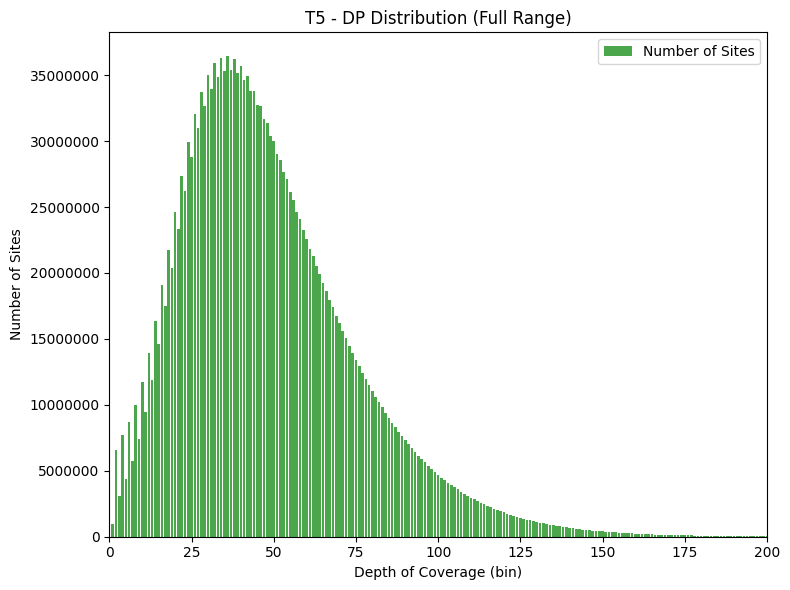

In [26]:
# Additional histogram for T5
plt.figure(figsize=(8, 6))
filtered_df_T5 = dp_dfs['T5'][dp_dfs['T5']['bin'] <= 200]
plt.bar(filtered_df_T5['bin'], filtered_df_T5['number_of_sites'], color='green', alpha=0.7, label='Number of Sites')
plt.title("T5 - DP Distribution (Full Range)")
plt.xlabel("Depth of Coverage (bin)")
plt.xlim(0, 200)
plt.ylabel("Number of Sites")
plt.ticklabel_format(useOffset=False, style='plain')
plt.legend()
plt.tight_layout()
plt.show()